In [2]:
%load_ext lab_black

ModuleNotFoundError: No module named 'lab_black'

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn

## Generating the dataset

We generate a mock dataset of points within two gausians and their labels.

In [10]:
# Forcing the random seed for reproductibility
np.random.seed(seed=42)
# Generating distributions
first_distribution = np.random.normal(-2.0, 1.0, size=(10000, 2))
second_distribution = np.random.normal(2.0, 1.0, size=(10000, 2))
all_points = np.concatenate((first_distribution, second_distribution), axis=0)
# Labels
labels = [0] * first_distribution.shape[0] + [1] * second_distribution.shape[0]

In [11]:
all_points.shape, len(labels)

((20000, 2), 20000)

In [12]:
df = pd.DataFrame()
df["x"] = all_points[:, 0]
df["y"] = all_points[:, 1]
df["label"] = labels
df.head()

,x,y,label
0,-1.503286,-2.138264,0
1,-1.352311,-0.476970,0
2,-2.234153,-2.234137,0
3,-0.420787,-1.232565,0
4,-2.469474,-1.457440,0


In [13]:
sns.scatterplot(data=df, x="x", y="y", hue="label")

NameError: name 'sns' is not defined

In [20]:
all_points

tensor([[-1.5033, -2.1383],
        [-1.3523, -0.4770],
        [-2.2342, -2.2341],
        ...,
        [ 1.0232,  3.1197],
        [ 2.2650,  2.6165],
        [ 2.8146,  2.3560]])

## Train, test, and validation split

We need a test set to evaluate our final model, and a validation set to make sure we don't overfit to the training data.

In [18]:
all_points = torch.tensor(all_points, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    all_points,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

C:\Users\chars\AppData\Local\Temp\ipykernel_2468\488684302.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_points = torch.tensor(all_points, dtype=torch.float32)
C:\Users\chars\AppData\Local\Temp\ipykernel_2468\488684302.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)


In [19]:
X_train

tensor([[-1.0846, -2.5495],
        [-3.4364, -1.4499],
        [-2.1237, -1.5422],
        ...,
        [-0.0953, -2.0065],
        [ 2.3816,  2.7234],
        [-4.4862, -0.8799]])

## Logisitic regression classifier

In [15]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

## Training the model

In [16]:
model = LogisticRegression(2, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [21]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

torch.Size([12800, 2]) torch.Size([12800, 1]) torch.Size([3200, 2]) torch.Size([3200, 1])


In [22]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(1.4582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2424, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1700, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1671, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1664, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1662, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyBackward0>)
CPU times: total: 4.48 s
Wall time: 1.27 s


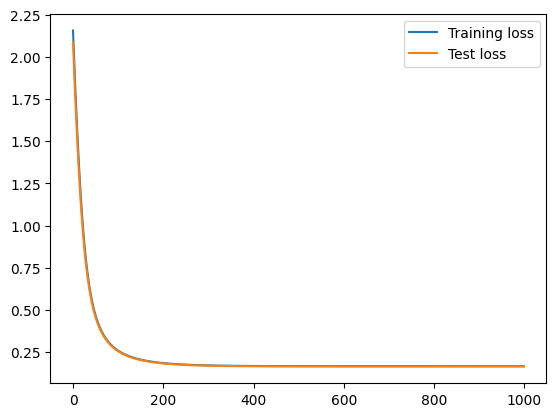

In [36]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [37]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.99734375 0.9975 0.99775


In [38]:
# Predicting new samples
model(torch.tensor([[-2.0, -1.5], [2, 1.5]], dtype=torch.float32))

tensor([[0.1587],
        [0.8417]], grad_fn=<SigmoidBackward0>)

In [39]:
# Looking at the model's weights and bias.
model.classifier[0].state_dict()["weight"], model.classifier[0].state_dict()["bias"]

(tensor([[0.4764, 0.4779]]), tensor([0.0014]))

## Training model, but better

The best practice with PyTorch is to return the logits and not the results of the activation function. Doing so allows to use an [implementation trick](https://en.wikipedia.org/wiki/LogSumExp) which gives better stability at training. The following code uses this trick. It removes the activation function from the model and uses the corresponding ...WithLogitsLoss function.

In [14]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)

In [15]:
model = LinearRegression(2, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [16]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

tensor(0.2684, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1849, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1704, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1671, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1663, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1662, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.1661, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
CPU times: user 3.38 s, sys: 0 ns, total: 3.38 s
Wall time: 566 ms


Notice how the training was faster. This is due to the implementation trick.

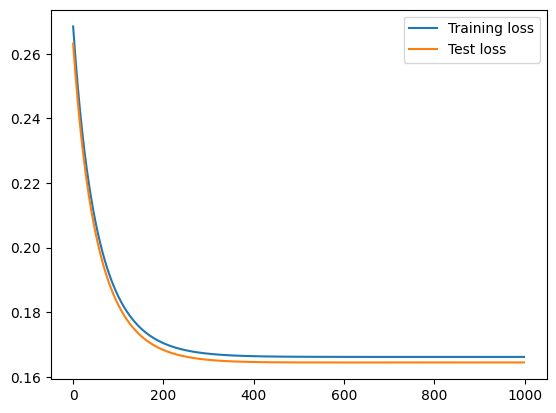

In [17]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [18]:
# Note that we need to use a sigmoid on the output now.
with torch.no_grad():
    p_train = torch.sigmoid(model(X_train))
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = torch.sigmoid(model(X_valid))
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = torch.sigmoid(model(X_test))
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.99734375 0.9975 0.99775


In [19]:
# Predicting new samples, we need to use a sigmoid on top of the output.
torch.sigmoid(model(torch.tensor([[-2.0, -1.5], [2, 1.5]], dtype=torch.float32)))

tensor([[0.1587],
        [0.8418]], grad_fn=<SigmoidBackward0>)